## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3ht2_igg because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# path_data_RCA = os.path.join(dataset.DATA_DIR, 'RCA_subset.csv')
# df = pd.read_csv(path_data_RCA, encoding='latin1')

In [3]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-CNN.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')

In [4]:
df_dropped = df.drop(dataset.FEATURES_UFO, axis=1)
df_dropped = df_dropped.drop(columns=['Predicted Class', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

In [5]:
print(df_dropped.columns.to_list())

['Unnamed: 0', 'PropertyKey_ID', 'Deal_id', 'Property_id', 'Status_tx', 'Status_dt', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Deal_Update_dt', 'Property_Update_dt', 'Excess_Land_Potential_fg', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'MaxChanged_dt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'PSF/PPU', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'age_right', '_merge']


## Prediction

In [6]:
# xgb_model_params = {'tree_method': 'hist'}
# xgb_hyperparams = {
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 500,
#     'colsample_bytree': 0.5,
#     'subsample': 1.0,
# }

xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 13,
    'learning_rate': 0.025,
    'n_estimators': 1000,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.5
}

### Regression

Here we deliberately predict "YearBlt" given that YearBlt and age_right (EUBUCCO age variable) have a correlation of 0.6 for NLD. In contrast, YearBlt_new2 has a correlation of only 0.22 with age_right from EUBUCCO.

2024-04-25 11:04:57,720 | INFO : Dataset length: 6141
2024-04-25 11:04:57,727 | INFO : Dataset allocated memory: 9 MB
2024-04-25 11:04:57,746 | INFO : Train set _merge distribution: {'left_only': 4514, 'both': 398}
2024-04-25 11:04:57,747 | INFO : Test set _merge distribution: {'left_only': 1130, 'both': 99}
2024-04-25 11:04:57,748 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-4dc976b2.abort.
2024-04-25 11:04:57,749 | INFO : Dataset standard deviation: 98.0140170021147
2024-04-25 11:04:57,750 | INFO : Dataset mean age: 1967.291320631819
2024-04-25 11:04:57,751 | INFO : Training dataset length: 4912
2024-04-25 11:04:57,752 | INFO : Test dataset length: 1229


2024-04-25 11:04:57,852 | INFO : Features selected are: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'PSF/PPU', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb']
2024-04-25 11:04:57,859 | INFO : Test dataset standard deviation after preprocessing: 23.764547531229983
2024-04-25 11:04:57,859 | INFO : Test dataset mean age after preprocessing: 1987.750450450

Applying categorical_to_int_byList to variables: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx']
Applying convert_to_double_byList to variables: ['Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'PSF/PPU', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb']


2024-04-25 11:05:00,947 | INFO : Energy need for heating in kWh/(m²a) R2: 0.5876
2024-04-25 11:05:00,948 | INFO : Energy need for heating in kWh/(m²a) MAPE: 0.3245
2024-04-25 11:05:00,948 | INFO : Energy need for heating in kWh/(m²a) MAE: 22.00
2024-04-25 11:05:00,949 | INFO : Energy need for heating in kWh/(m²a) RMSE: 34.92


MAE: 14.91 y
RMSE: 19.81 y
R2: 0.3042
Energy need for heating in kWh/(m²a) R2: 0.5876
Energy need for heating in kWh/(m²a) MAPE: 0.3245
Error metrics by _merge:
       Group        MAE       RMSE        R2
0       both  17.191107  23.114799  0.196710
1  left_only  14.695376  19.476717  0.314132
left_only
1015
1015


FixedFormatter should only be used together with FixedLocator


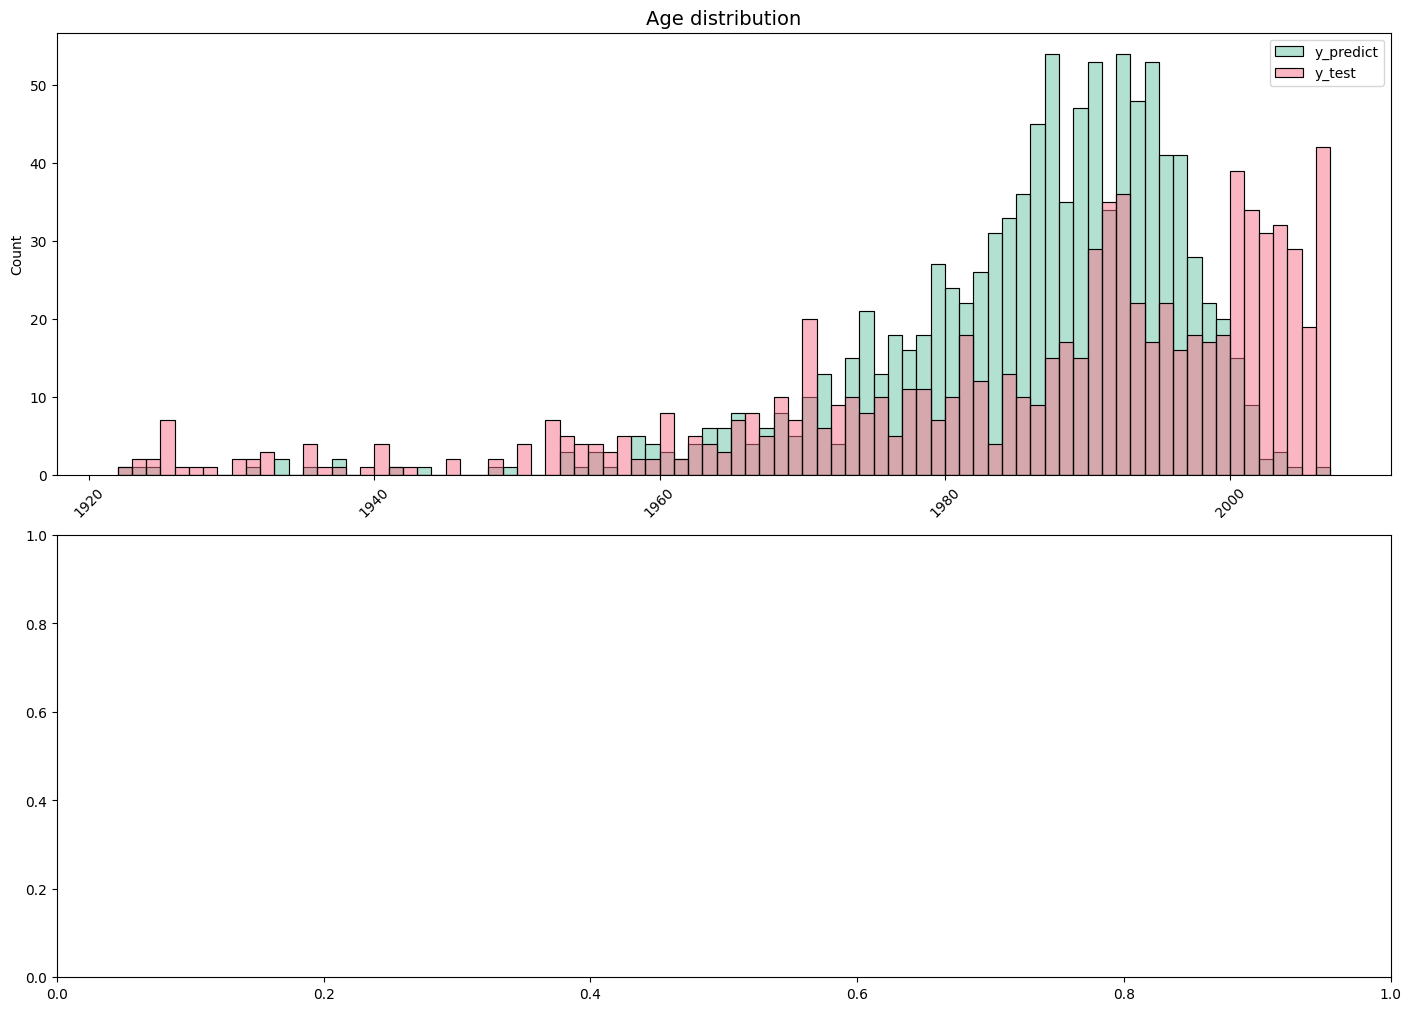

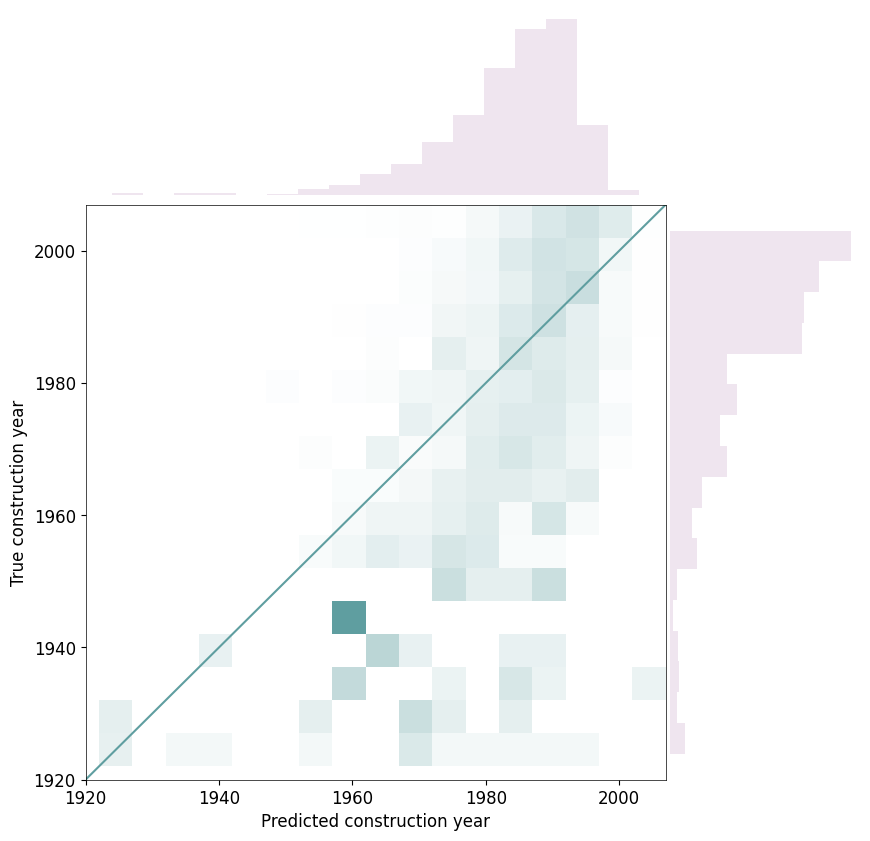

both
95
95


FixedFormatter should only be used together with FixedLocator
invalid value encountered in divide


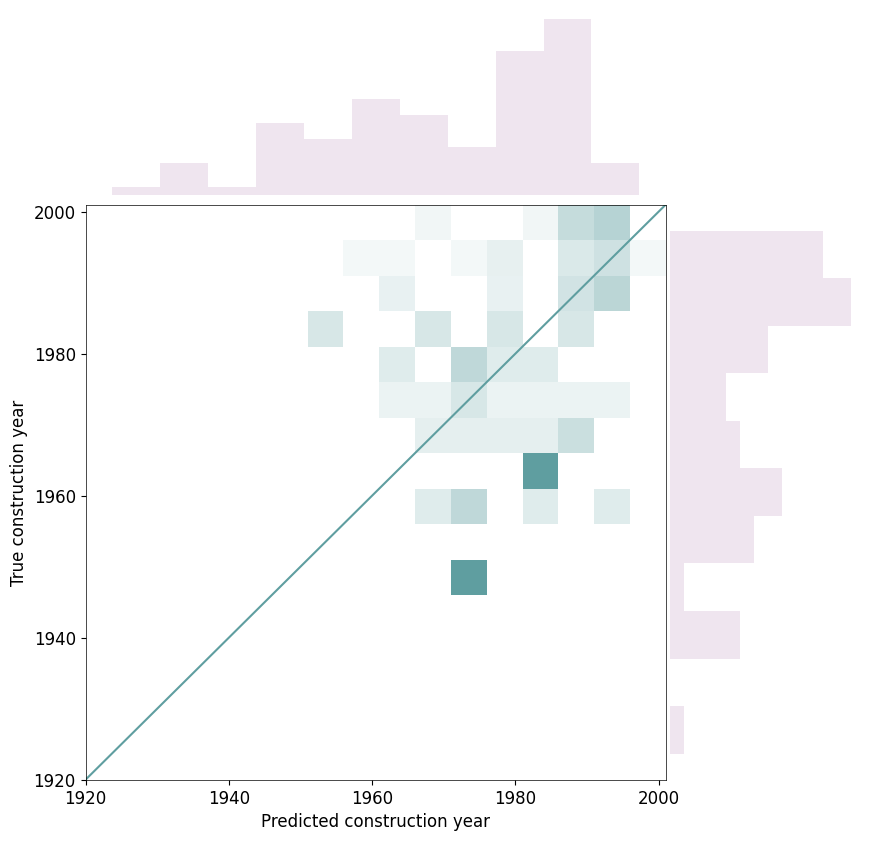

In [8]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.balanced_split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
)

predictor.evaluate(balanced_attribute = "_merge")


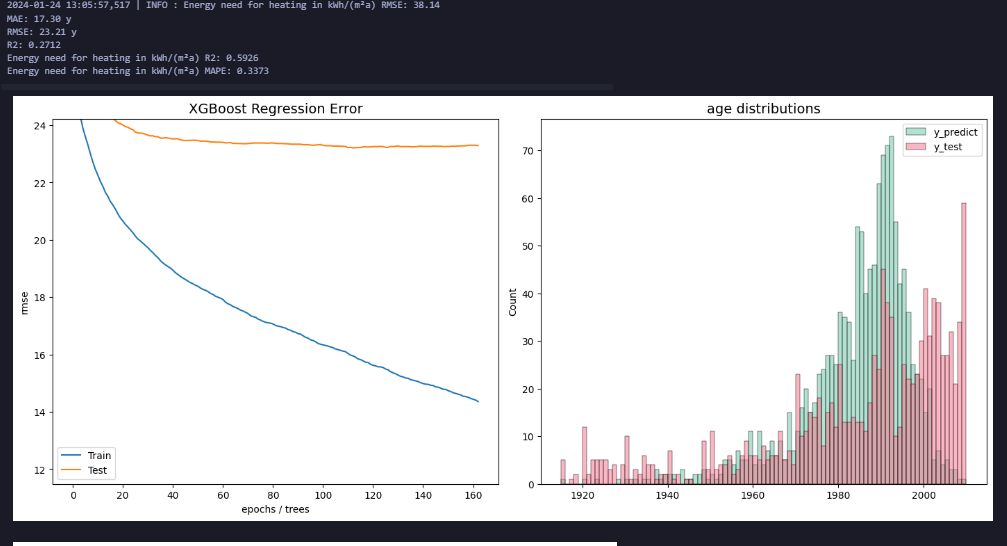
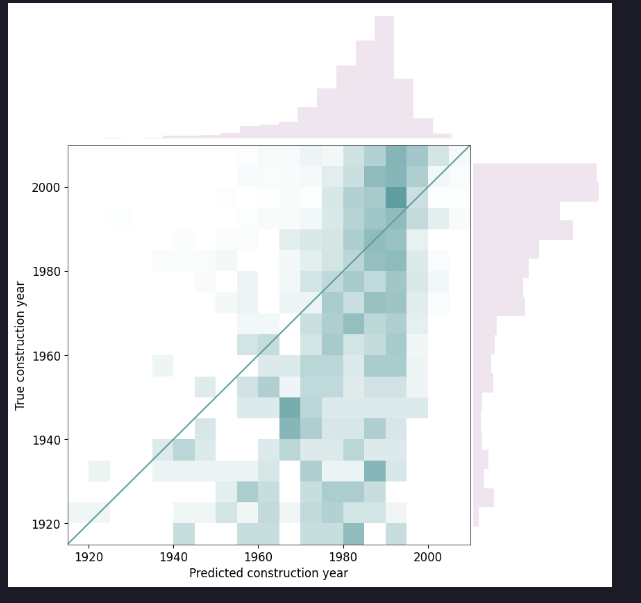

### Classification

2024-04-25 11:07:31,237 | INFO : Generated bins: [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]
2024-04-25 11:07:31,238 | INFO : Generated bins with the following labels: ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
2024-04-25 11:07:31,250 | INFO : Dataset length: 6141
2024-04-25 11:07:31,257 | INFO : Dataset allocated memory: 9 MB
2024-04-25 11:07:31,271 | INFO : Train set _merge distribution: {'left_only': 4514, 'both': 398}
2024-04-25 11:07:31,272 | INFO : Test set _merge distribution: {'left_only': 1130, 'both': 99}
2024-04-25 11:07:31,273 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-8f01a7a5.abort.
2024-04-25 11:07:31,274 | INFO : Training dataset length: 4912
2024-04-25 11:07:31,274 | INFO : Test dataset length: 1229
2024-04-25 11:07:31,276 | INFO : Test cities: ['Oss' 'Madrid' 'Muiden' 'Haarlem' 'Seclin' 'Bergen op Zoom' 'Seville'
 'Utrecht' 'Hoofddorp' 'Dedemsvaar

Applying categorical_to_int_byList to variables: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx']
Applying convert_to_double_byList to variables: ['Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'PSF/PPU', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb']
Classification report:
               precision    recall  f1-score  support
1900-1944      0.382114  0.635135  0.477157       74
1945-1969      0.307087

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


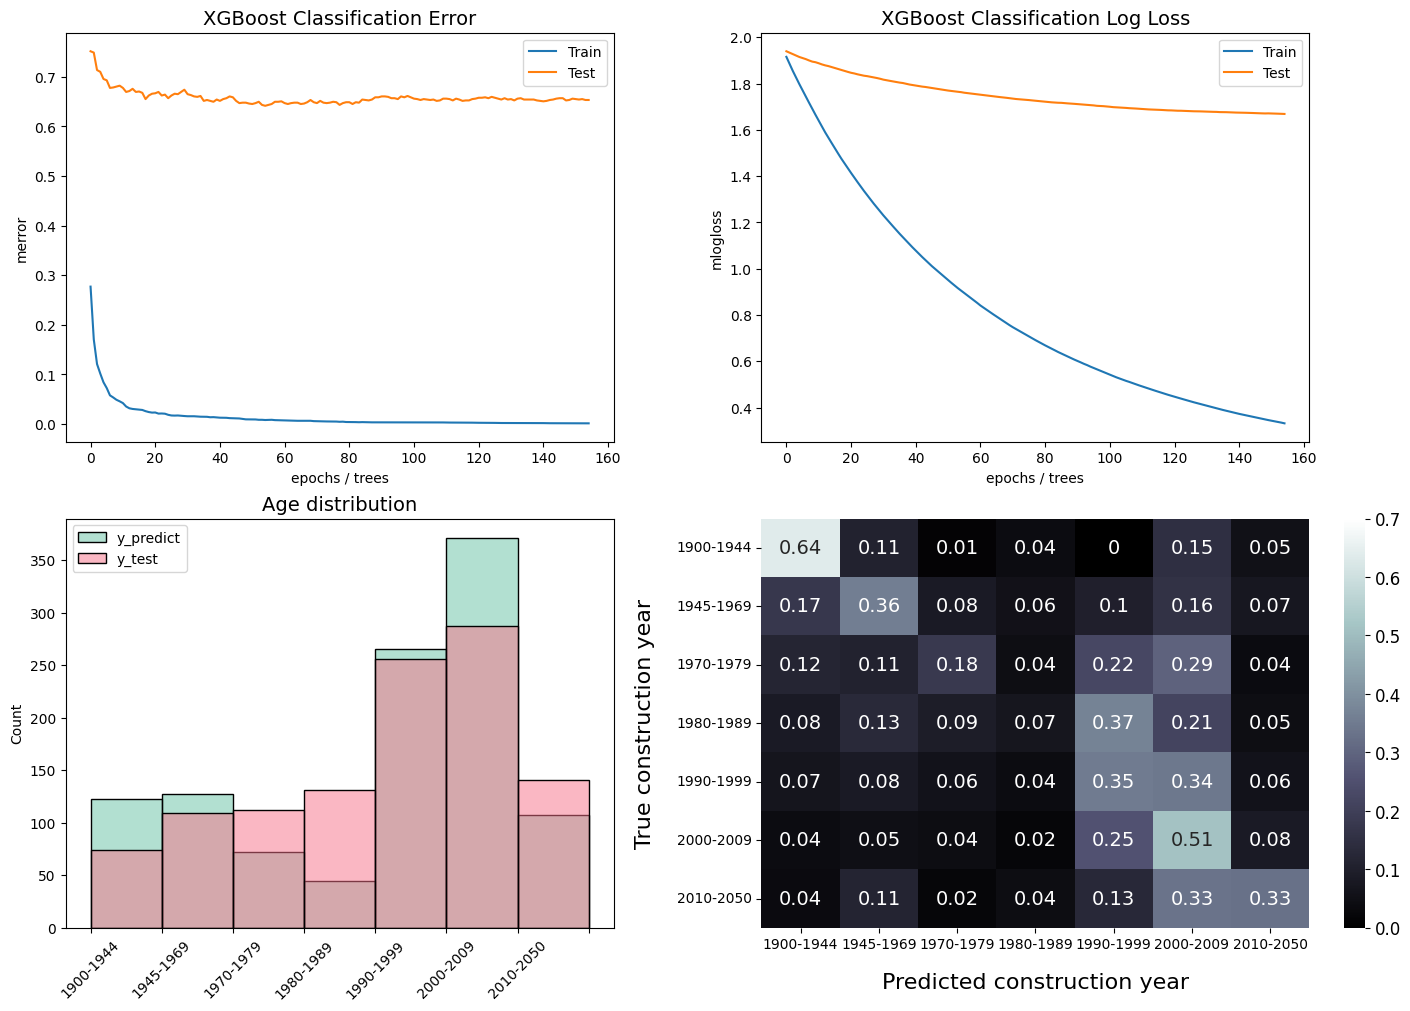

In [7]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.balanced_split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=equally_sized_bins,
)
classifier.evaluate(vmax=0.7)

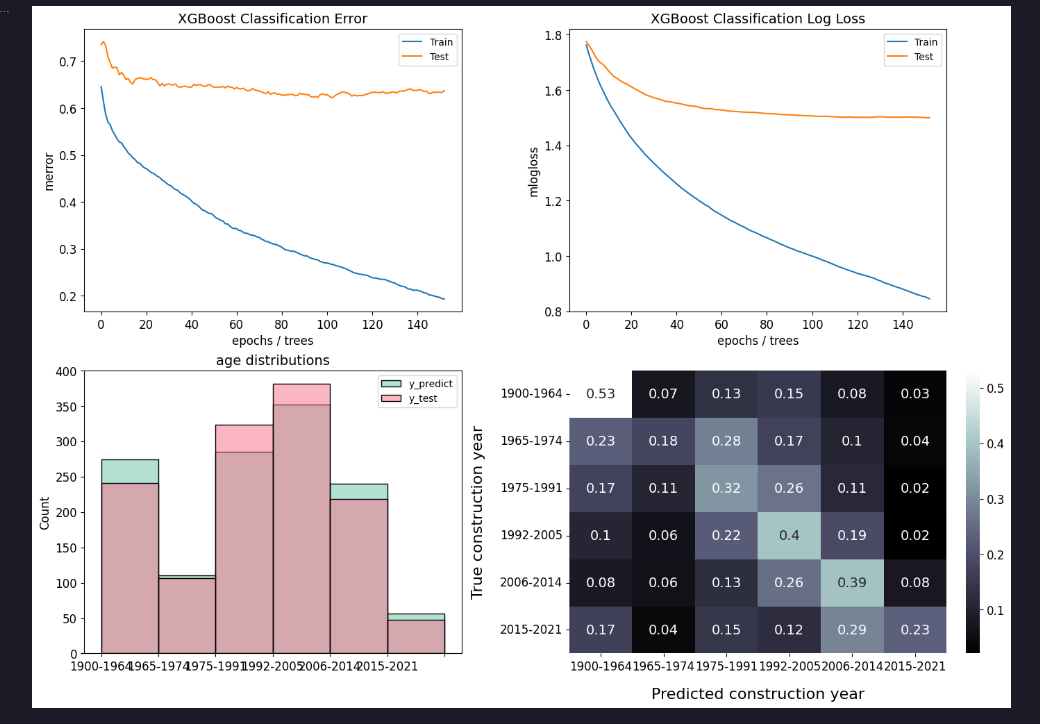

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [ ]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_dropped
gc.collect()